In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squidpy as sq

from anndata import AnnData

In [2]:
# index_col = 0 -> Set the first column as row name
raw_df = pd.read_csv('./brainCscaleddata.csv',
                     sep=',',
                     index_col=0).T
adata = AnnData(X=raw_df.to_numpy(), dtype=np.float32)
adata.obs['cell_id'] = raw_df.index
adata.var['gene_id'] = raw_df.columns
adata

AnnData object with n_obs × n_vars = 1803 × 32285
    obs: 'cell_id'
    var: 'gene_id'

### tissue_positions.csv
This text file contains a table with rows that correspond to spots. From Space Ranger v2.0 onwards this file, which was previously named tissue_positions_list.csv, is renamed and includes a header column. Excluding the header column, the file has 4,992 rows for Visium slides with a 6.5 mm Capture Area and 14,336 rows for Visium slides with 11 mm Capture Area which is the number of spots in the spatial array. Columns correspond to the following fields:
 - barcode: The sequence of the barcode associated to the spot.
in_tissue: Binary, indicating if the spot falls inside (1) or outside (0) of tissue.
 - array_row: For Visium slide (6.5 mm Capture Area), the row coordinate of the spot in the array from 0 to 77. The array has 78 rows. For Visium slides (11 mm Capture Area), the row coordinate of the spot range from 0 to 127 as the array has 128 rows.
 - array_col: The column coordinate of the spot in the array. In order to express the "orange crate" arrangement of the spots, for Visium slides (6.5 mm Capture Area) this column index uses even numbers from 0 to 126 for even rows, and odd numbers from 1 to 127 for odd rows with each row (even or odd) resulting in 64 spots. For Visium slides (11 mm Capture Area) this column index uses even numbers from 0 to 222 for even rows, and odd numbers from 1 to 223 for odd rows with each row (even or odd) resulting in 111 spots.
 - pxl_row_in_fullres: The row pixel coordinate of the center of the spot in the full resolution image.
 - pxl_col_in_fullres: The column pixel coordinate of the center of the spot in the full resolution image.

In [3]:
position_df = pd.read_csv('./tissue_positions_list.csv',
                          sep=',',
                          header=None,
                          index_col=0)
# set the column names
position_df.columns = ['in_tissue','array_row','array_col','pxl_row_in_fullres','pxl_col_in_fullres']
# relpace '-' to '.', example: AAACAAGTATCTCCCA-1 to AAACAAGTATCTCCCA.1
position_df.index = position_df.index.str.replace('-', '.')
# get the cell positions
cell_info_df = position_df.loc[list(adata.obs['cell_id'])]
# set the matrix position
adata.obs['x'] = cell_info_df['array_row'].to_numpy()
adata.obs['y'] = cell_info_df['array_col'].to_numpy()
# set the figure position
adata.obs['fig_x'] = cell_info_df['pxl_row_in_fullres'].to_numpy()
adata.obs['fig_y'] = cell_info_df['pxl_col_in_fullres'].to_numpy()

In [4]:
adata.obsm['spatial'] = np.vstack((adata.obs['x'].to_numpy(),adata.obs['y'].to_numpy())).T

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata

AnnData object with n_obs × n_vars = 1803 × 32285
    obs: 'cell_id', 'x', 'y', 'fig_x', 'fig_y', 'leiden'
    var: 'gene_id'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

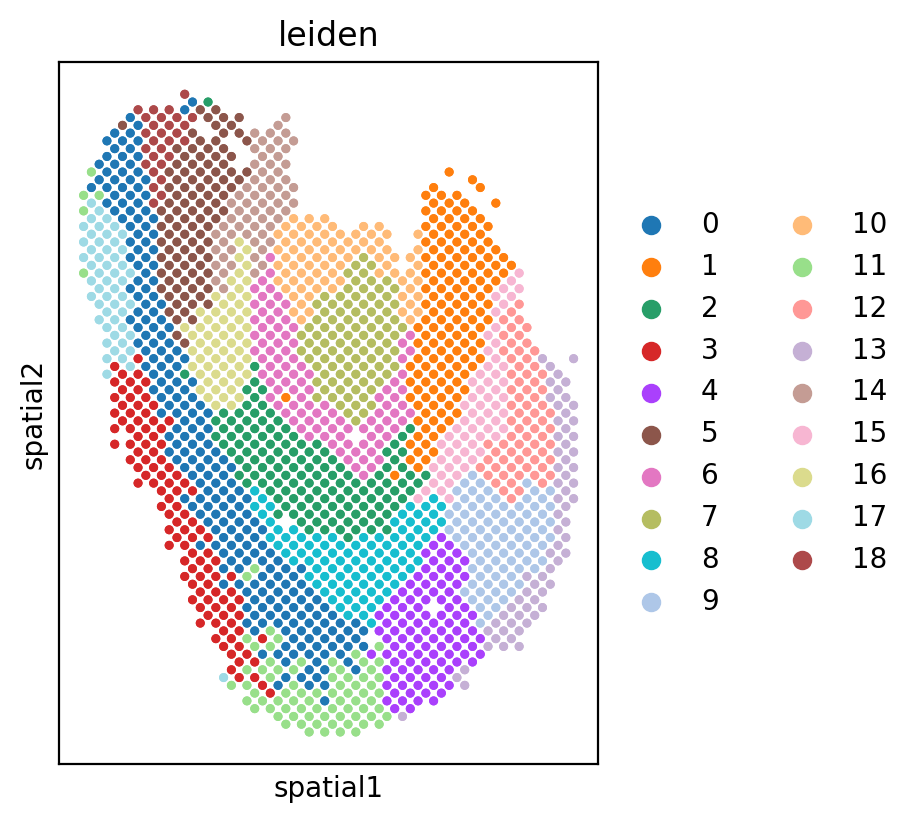

In [231]:
sq.pl.spatial_scatter(adata, shape=None, color="leiden", size=20, dpi=200)

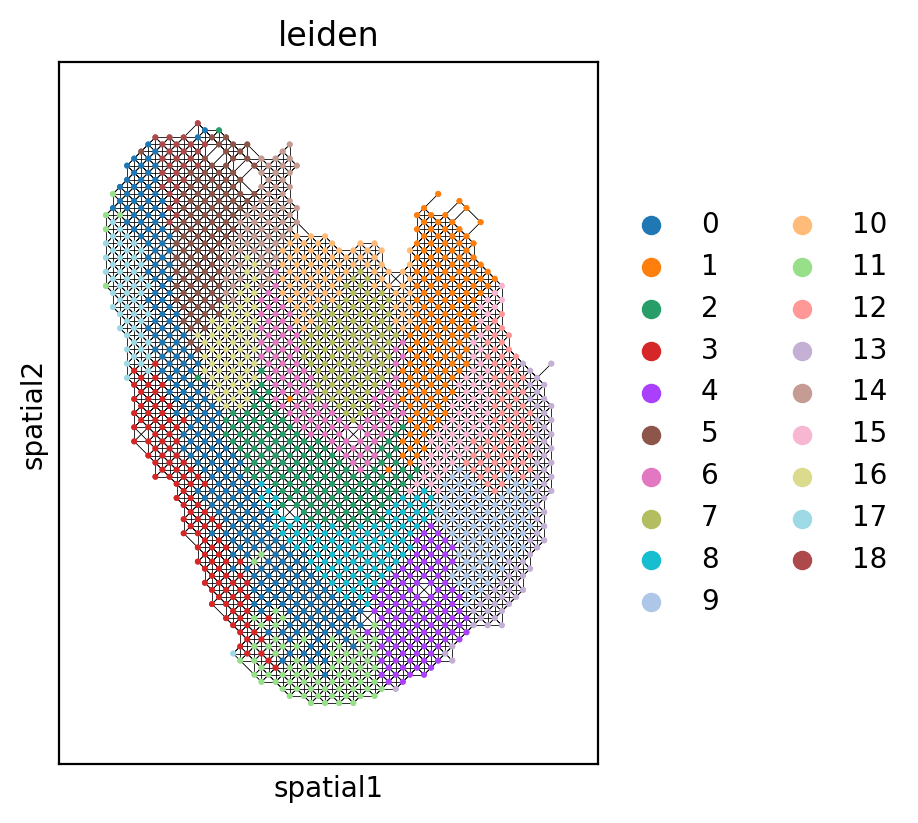

In [230]:
sq.gr.spatial_neighbors(adata, radius=3.0)
sq.pl.spatial_scatter(
    adata,
    color="leiden",
    connectivity_key="spatial_connectivities",
    edges_color="black",
    shape=None,
    edges_width=.2,
    size=5,
    dpi=200
)

f:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
f:\conda\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
f:\conda\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:xlabel='n_genes_by_counts'>

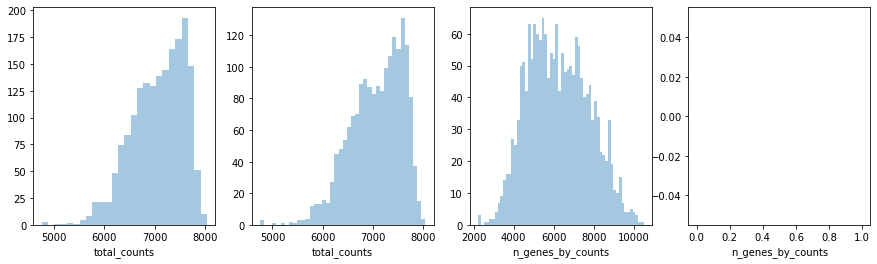

In [8]:
# Clean up data
sc.pp.calculate_qc_metrics(adata, inplace=True)
# Plot the raw data
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1000], kde=False, bins=60, ax=axs[3])


In [9]:
# Normalize genes count and log1p
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
# Select top 2000 variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)


In [10]:
# cluster
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

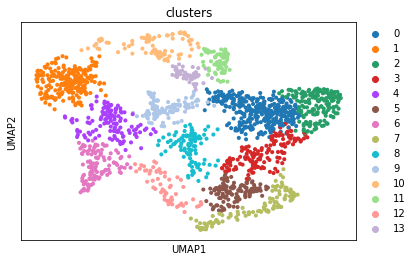

In [25]:
sc.pl.umap(adata, color=["clusters"], wspace=0.4)

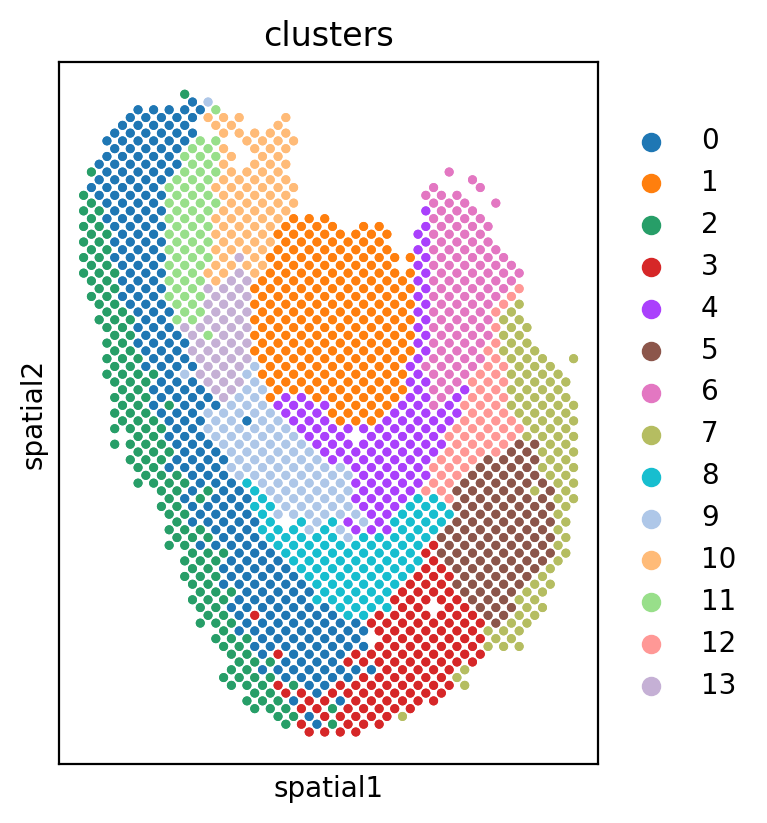

In [27]:
sq.pl.spatial_scatter(adata, shape=None, color="clusters", size=20, dpi=200)


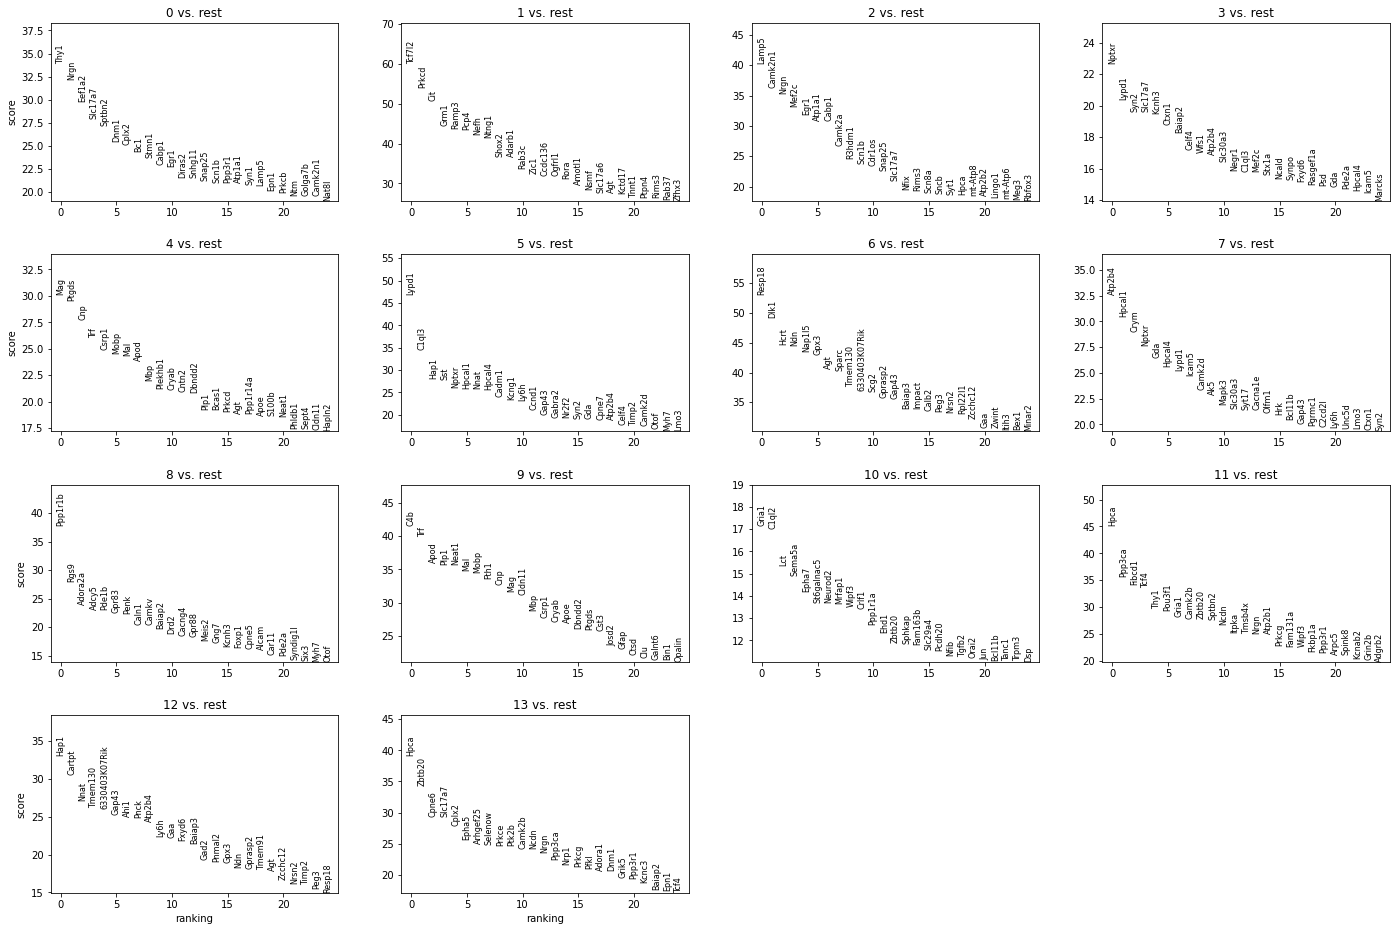

In [12]:
sc.tl.rank_genes_groups(adata, 'clusters', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols='gene_id')

In [24]:
adata

AnnData object with n_obs × n_vars = 1803 × 32285
    obs: 'cell_id', 'x', 'y', 'fig_x', 'fig_y', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'rank_genes_groups', 'hvg', 'clusters_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [29]:
from Bio import SeqIO